# Building Micrograd

Tiny autograd engine - implements backpropogation (reverse-mode-autodiff) over a dynamically built DAG (engine.py)

and a small neural network library (nn.py) on top of micrograd engine with a Pytorch-like API

Both are tiny

The DAG only operates over scalar values (rather than vectors) - so we chop up each nueron into all of its individual tiny adds adn multiplies
- Simplifies things to help you grok backpropogation 

If you want to train bigger networks you need to use tensors - this helps computation but none of the math actually changes
 - Tensors are just "arrays" of scalars - large arrays allow us to take advangage of parrallism of computer - but math is the same

So start with scalars to grok backpropogation

Everything else is just efficiency (that being said there is a lot to efficiency hahaahhaha)

Backpropogation - recursively applies the chain rule so can find the derivative of g with respect to all of the different nodes

derivate tells us how the nodes affect the output - obviously this is useful to train the network

Backpropogation is much more general than neural networks - it jsut happens that it is very useful to train neural nets 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

NN are massive expressions, so need datastructures that maintain these expressions

build out value object 

In [221]:
class Value:

    def __init__(self,data, _children = (), _op = (), label = (), parent_grad = ()):
        self.data = data
        self._prev = set(_children)
            # _children will be a tuple but will be held as a set in the class _prev - just done for efficiency
        self._op = _op
        self.label = label

        #derivative
        self.grad = 0.0 # initialized at 0 - assume that value does not effect output at the start
        
        #backpop funciton
        self._backward = lambda: None

    def __repr__(self):
        #python interally uses this repr function to return this string when the object is called on its own
        return f"Value(data={self.data})"
    
    #need to define addition
    def __add__(self,other):
        #use special underscore emthods to define operators in pytho
        # e.g. if we od a + b, python will interally do a.__add__(b)
        out = Value(self.data + other.data, _children = (self,other), _op = "+" )#this operator works as it is operating on self.data which is jsut a python number rather than our value class, second part is feeding in the _children expression to the new value obejct
        
        # definint g the function that propgates the gradient
        def _backward():
            # we want to propogate outs.grad and change self.grad and other.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * self.grad

            # #recursive call ?not implemented
            # self._backward()
            # other._backward()
        out._backward = _backward

        return out
    
    #same for multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), "*") #this operator works as it is operating on self.data which is jsut a python number rather than our value class
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

            # #recursive calls - think abotu variable scope it makes ense
            # self._backward()
            # other._backward()
        out._backward = _backward
        
        return out
    
    
    #defined activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh") #only 1 child

        def _backward():
            
            self.grad += out.grad * (1 - t**2)
            
            #having a bit of trouble figuring out the variable scope here
            #this function is not kept as a string but insted references the object pointers used when initializing it
            # when we "set" the function below
            # the function references self from the current variable scope - inside the tanh funciton where self refers not to the out Value but to the value which will create out

            # some simple debugging
            # print whatever self is when reference - when we call out._backwards we will see it prints the current self rather than out itself
            # This sounds schizophrenic but makes sense if you think about it enough
            # when you 

            # I have read the docs and returned wiser
            # when you define the function you bind the function tot he local namespace and the function object 
            # containes reference tot eh current global namespace as the flobal namespace tot be used when the 
            # function is called
            # so when we define the function ehre it remembers this tanh() function as the namespace and within
            # this space self refers to the object that is to create out
            # MAEKS SESNE
            # https://docs.python.org/3/reference/compound_stmts.html#function
            # print(self)
            
            # recusrive call not implemented
            # self._backward()


        out._backward = _backward
        
        return out
    

    #also want to make the connective tissue of the expression - keep expression graphs simple pointers
    #_children argument added

    #also need to know what operation created each value
    #_op


    #also want a way to visualize these expressions
    #see cell below

    # add labels _label

    #add another variable which keeps track of the derivative of L with respect to that value

    # #my attempt at writing it - to compare with the GOAT
    # def backprop(self, _parent_grad = (), _op = (), _sibling = ()):
        
    #     # Dont use unnecesary parent grad variable
    #     # can convey all the information reqiured for recursive function in the function call
    #     # previuosly used self.parent_grad function - uneccesary

    #     print(self.label, _parent_grad, _op, _sibling)
        
    #     if _parent_grad == ():
    #         #base case
    #         self.grad = 1 
    #         #derivative with respect to itself will be 1 always

    #     else:
    #         # apply chain rule using the parent grad
    #         if _op == "*":
    #             self.grad = _parent_grad * _sibling.data # parent = c1 * c2 ; dparent/dc1 = c2
    #         elif _op == "+":
    #             self.grad = _parent_grad * 1 # parent = c1 + c2 ; dparent/dc1 = 1 + 0 = 1

    #     if self._prev != set():
    #         #each nodes is assumed to have 2 children
    #         child1 , child2 = self._prev
            
    #         #unnecessarily pass sibling node even if addition
    #         child1.backprop(_parent_grad = self.grad, _op = self._op, _sibling = child2)
    #         child2.backprop(_parent_grad = self.grad, _op = self._op, _sibling = child1)

    # Kaprpathy backpopogates through each operation
    # ?just changes the childern directly and hten backprops through - makes way more sense as can handle larger sums :)
    # ?still need to check base case 
    # Karpathy getting fucking clever and using almbda functions
    # written into the code of building a network he specifies how to backprop over it 
    # seems weird but we will trust the GOAT
    
    def backward(self):
        #actaul backprop function - builds topolical tree and applies _backward attribute on it
    
        # building a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)       
                topo.append(v) #only adds itself after all the children are processed
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
        
            

 
    




In [68]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a*b;e.label = "e" #karpathy flexing the semicolon
d = e + c; d.label = "d" 
f = Value(-2.0,label = "f")
L = d * f; L.label = "L" #output of the graph


In [74]:
a._prev == set()

True

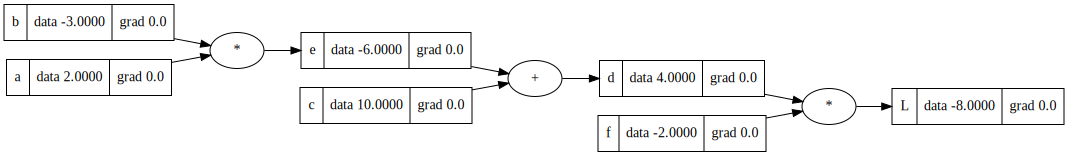

In [69]:
# writing up a little function that installs 

from graphviz import Digraph

def trace(root):
    # root = starting Value object to build tree from

    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child) #recursive call to repeat addition on each child
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr={"rankdir":"LR"}) #LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any vlaue in hte graph, create a rectuangular ("record") node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %s}" % (n.label, n.data,n.grad), shape = "record")
        if n._op: #if n is the result of an opertaion
            #if this value is a result of some operation, creat an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid+n._op,uid)
    
    for n1, n2 in edges:
            # connect n1 to the op node of n2
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)


# now we want to add back propogation

reverese and calculate the gradient across all these intermediate valued

we are going to compute 
$dL/dnode$ for each node

**We can image that these nodes could be weights in a neural net and L could be the loss function so we want to see how to move the weights to decrease L**

data itself will also be nodes - but we dont care about the gradient here as the data is fixed

In [38]:
#manual backpropogation
L.grad  = 1.0

# d and f
# L = d * f
# dL/dd = f
f.grad = d.data
d.grad = f.data

## this is the most important node to understand to understand backpropogation

$\dfrac{dL}{dc}$

## Chain rule baby

$\dfrac{dy}{dx} = \dfrac{dy}{du}\dfrac{du}{dx} $

In [ ]:
# since we know the derivative of dL/dd we can use this information - WOWOWOWO
# THATS WHY HE SAID CHAIN RULE WAS SO IMPORTANT

# we know d = c + e
# dd/dc = 1 $

# dL/dc = dL/dd * dd/dc = f * 1 
#easy pesy
#each node has information locally - which can be chained together - quantizaiton? not sure if that is a technically correct term but you know what I mean

In [35]:
# create a gating function so to not mess up the global scope - messing around with derivatives

def temp_func():

    #all of these will be local variables to thsi function

    h = 0.0001

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a*b;e.label = "e" #karpathy flexing the semicolon
    d = e + c; d.label = "d"
    f = Value(-2.0,label = "f")
    L1 = d * f; L.label = "L" #output of the graph

    a = Value(2.0 + h, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a*b;e.label = "e" #karpathy flexing the semicolon
    d = e + c; d.label = "d"
    f = Value(-2.0,label = "f")
    L2 = d * f; L.label = "L" #output of the graph

    print( (L2.data - L1.data )/ h)

temp_func()


6.000000000021544


{Value(data=10.0), Value(data=-6.0)}


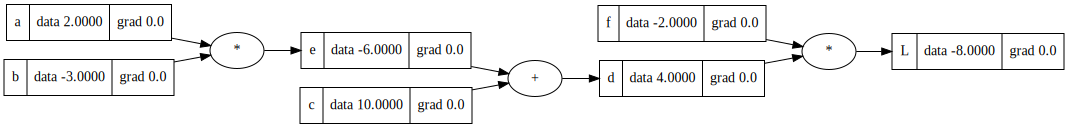

In [114]:
def backprop_test():
    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a*b;e.label = "e" #karpathy flexing the semicolon
    d = e + c; d.label = "d"
    f = Value(-2.0,label = "f")
    L = d * f; L.label = "L" #output of the graph

    print(d._prev)

    return draw_dot(L)


backprop_test()


## optimization

nudge all of the nodes in the opposite direction of the gradient (to reduce L)

Another crack at manual backpropogation - now going throuhg neurons

Simplest neural network = MULTILAYER PERCEPTORON

Neurons are complex - but our mathmatical representations of them are not that complex-  thanks to the crazy math dude

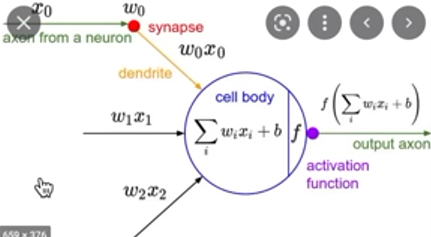

Axon (output from previous neuron) and synapse (weight at that node) interact multiplicatively and pass informaiton through dendrite

$w0*x0$

neuron sums the incoming dendrites + som bias

$ \displaystyle \sum_{i} w_ix_i + b $

then passes this through an activation funciton and outputs it through its axon

$ \displaystyle output = f(\sum_{i} w_ix_i + b )$

often a squashing funciton tanh, sigmoid, or relu




## using tanh

we want to make a tanh so we also need to implement a exponential function and a divide

But we dont actually need everything to be perfectly atomic

we can make functions at arbitraty levels of abstraction 

so we can just make a tanh as long as we know the analytical function of its derivative and thus how to "differentiate thorugh it"

so we will directly implement tanh

and we know analyticall that the local derivative it

$dtanh/dx = 1 - tanh^{2}(x) $

In [222]:
#inputts x1,x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias 
b = Value(6.8813735870195432, label = "b")

#neuron x1w1 + x2w2 + b
# need to do intermediate steps
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"

O = n.tanh() ; O.label = "O"
#n.backprop(_parent_grad = 0.5)


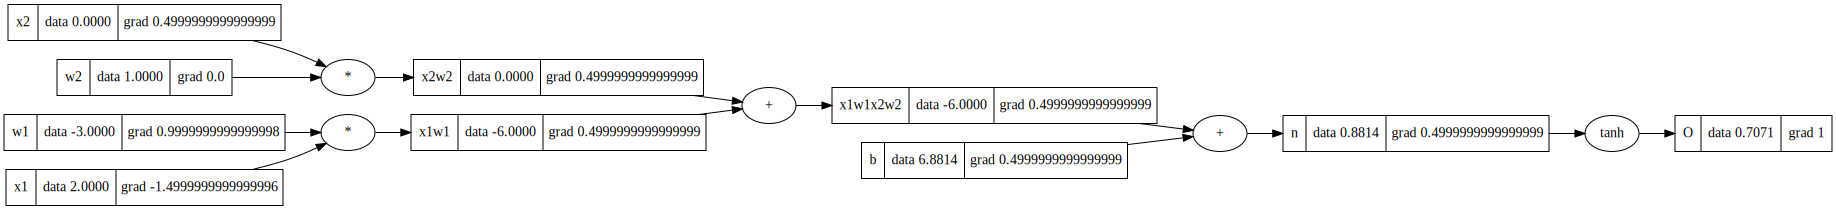

In [195]:
draw_dot(O)


In [194]:
# #as back case we need to set O.grad = 1
# O.grad = 1
# O._backward() #since ) was hte outcome of a tanh operation its backward functionw as set to the inverse of tanh


# #inspect.getsource(O._backward)

# implementing backward propogation over the whole graph

need to make sure that we do all of the operations in hte correct order

?could do it recursively

instead karpathy does "TOPOLOGICAL SORT"

see backward method in Value class

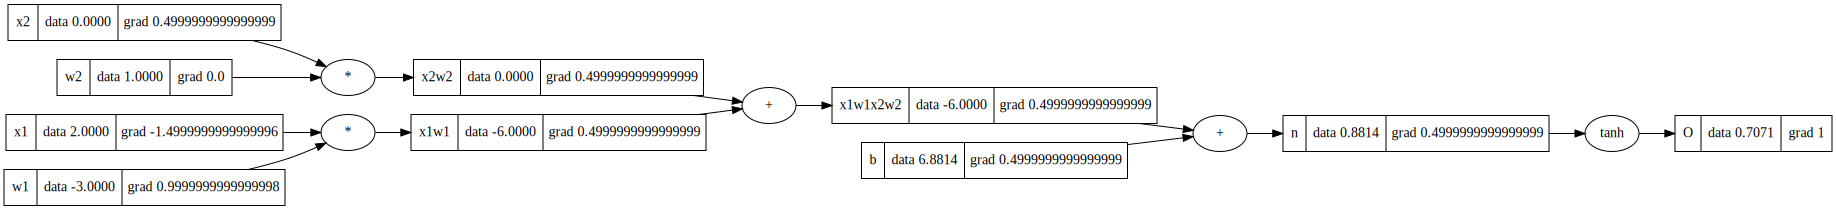

In [223]:
O.backward()

draw_dot(O)

# we have a bad bug at the moment

hmmmm

Multiple assignments overide 

THIS IS IMPORTANT WHEN A NODE FEEDS INTO MULTIPLE FUTURE NODES - IT WILL BE OVERWRITTEN

HMMM - need a way to go layer by layer

we need the multivariate chain rule to save us

luckily if hte function is addition then the gradients simply add :)
All of out overlapping functions are additions so this holds well
?? I am not sure if this is exactly technically correct hmmmm

?gradients accumulate hmmmmm

so just change all the gradient assigments with +=

multivariable chain rule actually seems simple - all gradient accumulate

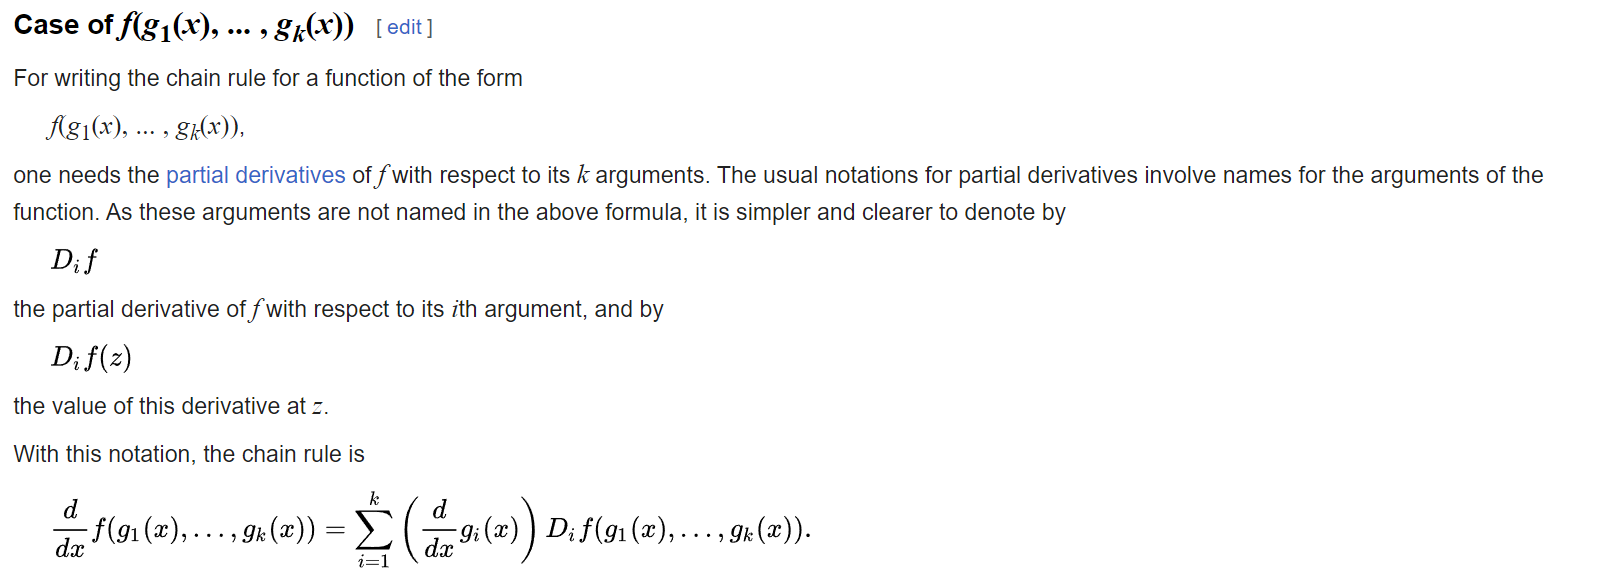



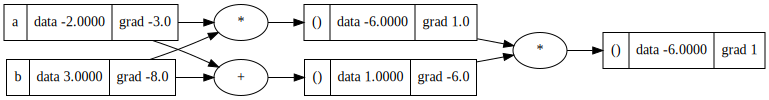

In [229]:
# a = Value(3.0) ; a.label ="a"
# b = a + a; b.label = "b"

#multiple reference means we override gradeint when running the _backward function

a = Value(-2.0,label = "a")
b = Value(3.0,label = "b")
d = a*b
e = a+b
f = d*e

f.backward()
draw_dot(f)

In [228]:
h = 0.00001

a = Value(-2.0+h,label = "a")
b = Value(3.0,label = "b")
d = a*b
e = a+b
f1 = d*e

a = Value(-2.0,label = "a")
b = Value(3.0,label = "b")
d = a*b
e = a+b
f2 = d*e

(f1.data - f2.data)/h

-2.999969999972762